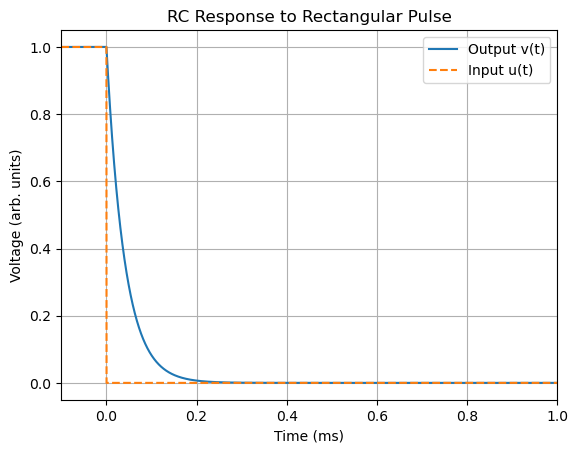

In [44]:
# April 15 2025
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as scc
from scipy.signal import hann

# Parameters
N = 2**20
T = 100 * scc.milli
dt = T / N
t = np.linspace(0, T, N, endpoint=False)

# Construct input rectangular pulse (centered 1/3 to 2/3)
u_t = np.zeros(N)
u_t[N//3 : 2*N//3] = 1

# FFT of input signal
U_w = np.fft.fft(u_t) * dt
w = 2 * np.pi * np.fft.fftfreq(N, d=dt) + np.finfo(float).eps

# RC circuit transfer function H(w) = 1 / (1 + i w RC)
R = 1 * scc.mega
C = 40 * scc.pico
H_w = 1 / (1 + 1j * w * R * C)

# Multiply in frequency domain and return to time domain
V_w = H_w * U_w
v_t = np.fft.ifft(V_w).real / dt  # rescale back
t0 = 2*T/3
# Plot if you want
plt.plot((t-t0) / scc.milli, v_t, label="Output v(t)")
plt.plot((t-t0)/ scc.milli, u_t, '--', label="Input u(t)")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (arb. units)")
plt.xlim(-.1,1)
plt.legend()
plt.grid()
plt.title("RC Response to Rectangular Pulse")
plt.show()


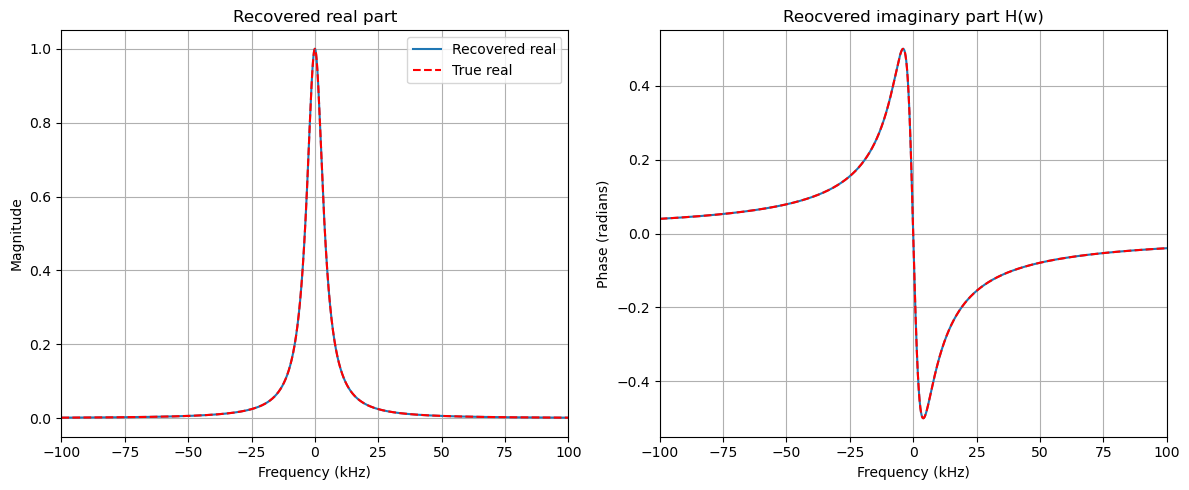

w (1048576,) t (1048576,)


In [45]:
# FFTs of input and output signals
V_w_recover = np.fft.fft(np.real(v_t)) * dt

# Avoid divide-by-zero: apply a threshold to |U(w)|
eps = 1e-10 * np.max(np.abs(U_w))
H_w_recovered = np.where(
    np.abs(U_w) > eps,
    V_w_recover / U_w,
    0
)

# Sort frequencies and corresponding H_w values for clean plotting
sort_idx = np.argsort(w)
w_sorted = w[sort_idx]
H_w_sorted = H_w_recovered[sort_idx]
H_w_true_sorted = H_w[sort_idx]  # optional: if you want to compare to ground truth

# Plot the magnitude and phase of recovered H(w)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(w_sorted / (2 * np.pi * 1e3), np.real(H_w_sorted), label="Recovered real")
plt.plot(w_sorted / (2 * np.pi * 1e3), np.real(H_w_true_sorted), '--r', label="True real")
plt.xlim(-100,100)
plt.title("Recovered real part")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Magnitude")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(w_sorted / (2 * np.pi * 1e3), np.imag(H_w_sorted), label="Recovered imag")
plt.plot(w_sorted / (2 * np.pi * 1e3), np.imag(H_w_true_sorted), '--r', label="True imag")
plt.xlim(-100,100)
plt.title("Reocvered imaginary part H(w)")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Phase (radians)")
plt.grid()

plt.tight_layout()
plt.show()
print("w",np.shape(w),"t",np.shape(t))


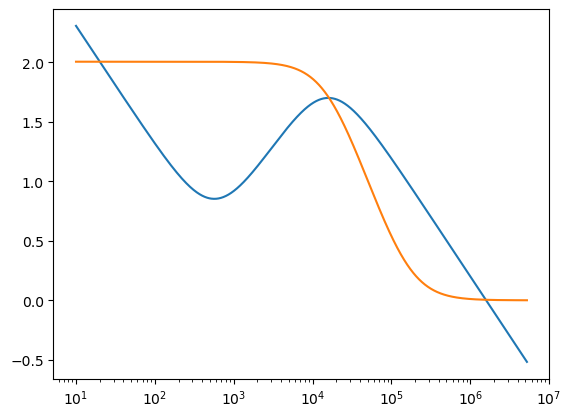

In [46]:
Temps = np.array([0,10,20,30,40,50])
rho = np.array([85.841,43.297,23.844,14.082,8.810,5.791])*10000
a,b,c = np.polyfit(Temps,np.log(rho),2)
def rho_W(Temperature):
    rho = np.exp(Temperature**2*a+Temperature*b+c)
    return rho 
def eps_sugar(omega,Temperature,tau):
    Delta_k = 100
    y = 1 +0*omega + 0j
    y -= 1j/(rho_W(Temperature-273.15)*scc.centi)/omega/scc.epsilon_0/10
    y += Delta_k/(1 + 1j*omega*tau)
    return y
tau = 1e-5
Temperature = 220
w2 = w[w>.1]
eps = eps_sugar(w2,Temperature,tau)
plt.plot((w2)/2/np.pi,np.log10(-np.imag(eps)))
plt.plot((w2)/2/np.pi,np.log10( np.real(eps)))
plt.xscale("log")
plt.yscale("linear")

t (1048576,) u_t (1048576,) v_t (1048576,) w (1048576,)


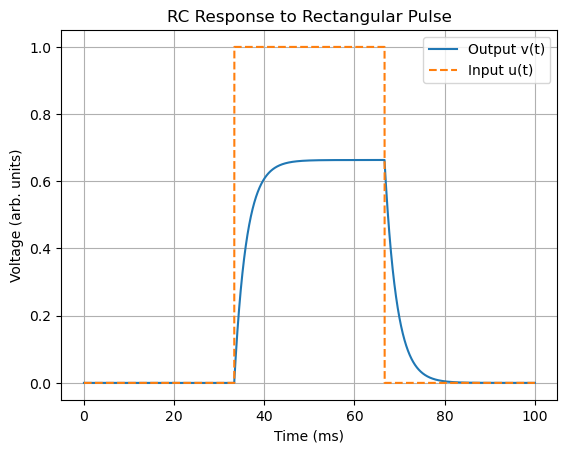

In [47]:
tau = 1e-5
Tk = 220
# Multiply in frequency domain and return to time domain
# RC circuit transfer function H(w) = 1 / (1 + i w RC)
R = 1 * scc.mega
C = 40 * scc.pico
H_w = 1 / (1 + 1j * w * R * C * eps_sugar(w,Tk,tau))
V_w = H_w * U_w 
v_t = np.fft.ifft(V_w).real / dt  # rescale back
print("t",np.shape(t),"u_t",np.shape(u_t),"v_t",np.shape(v_t),"w",np.shape(w))

# Plot if you want
plt.plot(t / scc.milli, v_t, label="Output v(t)")
plt.plot(t / scc.milli, u_t, '--', label="Input u(t)")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (arb. units)")
plt.legend()
plt.grid()
plt.title("RC Response to Rectangular Pulse")
plt.show()

# Next time
April 16, 2025:  This doesn't seem to quite work it seems to recover the function, but why is the frequency range narrowed??  Need to look into that.  Also I recover H_w, but I still need epsilon(w).  Do I just have to solve for this algebraicly? Also maybe need to test whether oscillations are just a phase oscillation and not worth worying about?

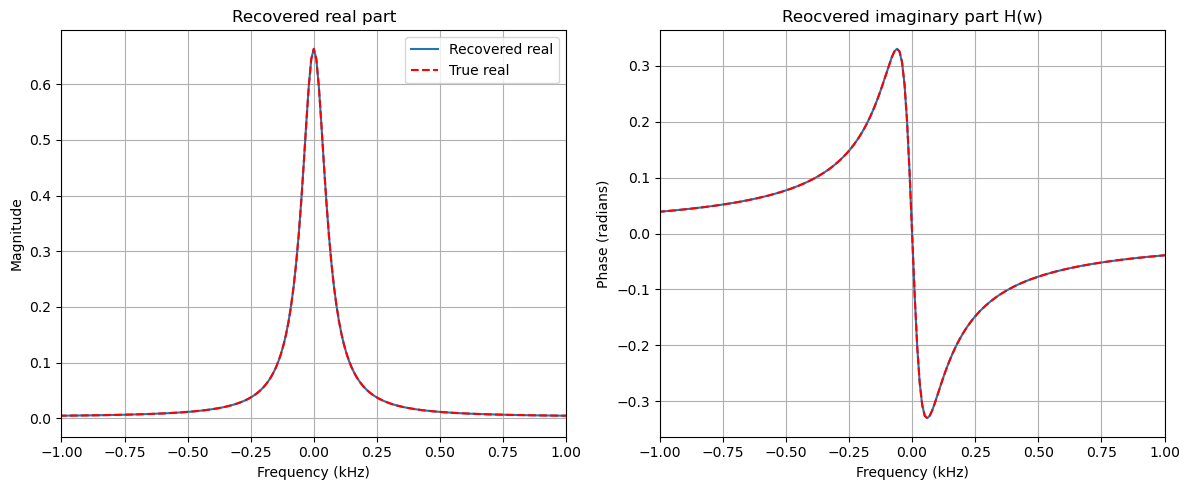

w (1048576,) t (1048576,)


In [51]:
# now try to recover frequency domain

V_w_recover = np.fft.fft(np.real(v_t)) * dt

# Avoid divide-by-zero: apply a threshold to |U(w)|
eps = 1e-10 * np.max(np.abs(U_w))
H_w_recovered = np.where(
    np.abs(U_w  ) > eps,
    V_w_recover / U_w,
    0
)

# Sort frequencies and corresponding H_w values for clean plotting
sort_idx = np.argsort(w)
w_sorted = w[sort_idx]
H_w_sorted = H_w_recovered[sort_idx]
H_w_true_sorted = H_w[sort_idx]  # optional: if you want to compare to ground truth

# Plot the magnitude and phase of recovered H(w)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(w_sorted / (2 * np.pi * 1e3), np.real(H_w_sorted), label="Recovered real")
plt.plot(w_sorted / (2 * np.pi * 1e3), np.real(H_w_true_sorted), '--r', label="True real")
plt.xlim(-1,1)
plt.title("Recovered real part")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Magnitude")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(w_sorted / (2 * np.pi * 1e3), np.imag(H_w_sorted), label="Recovered imag")
plt.plot(w_sorted / (2 * np.pi * 1e3), np.imag(H_w_true_sorted), '--r', label="True imag")
plt.xlim(-1,1)
plt.title("Reocvered imaginary part H(w)")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Phase (radians)")
plt.grid()

plt.tight_layout()
plt.show()
print("w",np.shape(w),"t",np.shape(t))
